In [10]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sdv.datasets.demo import download_demo
from sdv.lite import SingleTablePreset
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality, get_column_plot
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.single_table import CopulaGANSynthesizer
from NonParam_DataCopulas_mix.SDG_Copulas_NonParam import plot_comparision
from NonParam_DataCopulas_mix.SDG_Copulas_NonParam import generate_multivariate_data_mix

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator


In [11]:
def generate_report_FastML( metadata,real_data, num_rows,synthesizer_name='FAST_ML'): 
    synthesizer = SingleTablePreset(metadata, name=synthesizer_name)
    #Preprocessing assignation 
    synthesizer.fit(data=real_data)
    synthetic_data = synthesizer.sample(num_rows=num_rows)

    diagnostic = run_diagnostic(real_data=real_data, synthetic_data=synthetic_data, metadata=metadata)
    quality_report = evaluate_quality(real_data, synthetic_data, metadata)
    column_shapes = quality_report.get_details('Column Shapes')

    report = {
        'metadata': metadata,
        'diagnostic': diagnostic,
        'quality_report': quality_report,
        'original-Synthetic': {
            'original_data': real_data,
            'synthetic_data': synthetic_data
        }
    }
    #Display metadata visualization

    return report

def generate_report_CTGAN(metadata,real_data,samples,enforce_rounding=False,epochs=10,verbose=True):
    synthesizer = CTGANSynthesizer(metadata=metadata,
                                   enforce_rounding=enforce_rounding,
                                      epochs=epochs,
                                        verbose=verbose)
    synthesizer.auto_assign_transformers(real_data)
    synthesizer.get_transformers()
    synthesizer.fit(real_data)
    synthetic_data = synthesizer.sample(samples)
    
    diagnostic = run_diagnostic(real_data=real_data, synthetic_data=synthetic_data, metadata=metadata)
    quality_report = evaluate_quality(real_data, synthetic_data, metadata)
    column_shapes = quality_report.get_details('Column Shapes')
   

    report = {
        'metadata': metadata,
        'diagnostic': diagnostic,
        'quality_report': quality_report,
        'original-Synthetic': {
            'original_data': real_data,
            'synthetic_data': synthetic_data
        }
    }
    return synthetic_data

def generate_report_GaussianCopula(metadata,real_data,samples):
    synthesizer = GaussianCopulaSynthesizer(metadata=metadata)
                                            
    synthesizer.fit(real_data)
    synthetic_data = synthesizer.sample(samples)
    return synthetic_data

def generate_report_TVAE(metadata,real_data,samples):
    synthesizer = TVAESynthesizer(metadata=metadata)
    synthesizer.fit(real_data)
    synthetic_data = synthesizer.sample(samples)
    return synthetic_data

def generate_report_CopulaGAN(metadata,real_data,samples):
    synthesizer = CopulaGANSynthesizer(metadata=metadata)
    synthesizer.fit(real_data)
    synthetic_data = synthesizer.sample(samples)
    return synthetic_data


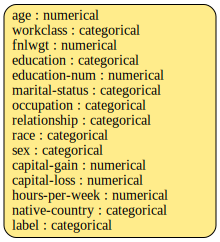

In [12]:
data, metadata = download_demo(
    modality='single_table',
    dataset_name='adult'
)
metadata.visualize()


In [13]:
#Dividing the dataset in original, and control. 
data=data.sample(30000)
original = data.sample(frac=0.8, random_state=200)
control = data.drop(original.index)

In [14]:
original.to_csv('adult_original.csv',index=False)
control.to_csv('adult_control.csv',index=False)
data.to_csv('adult.csv',index=False)

#### Dudas
- Que se hace con cada tipo de variable dentro de los modelos? 
    - rdt transformations according to the data type. The preprocessing is made inside the .fit function

- Entender bien la inferencia (rayar) (papers asociados)
- Correr todo para la misma base de datos (check)
- Que modelos (ref) se utilizaan en cada método? (check)

- Ver si para cada modelo se conservan las metricas multivariantes
- Hacer graficos para cada cosa
- Mirar parámetros de cada modelo y como afectan la sensibilidad
- Correr todos lo modelos y mirar resultados 
- Entender todos los modelos (almenos superficialmente)
- Implementar modelos con DP de 0 con tensorflow (almenos los ejemplos)


In [15]:
#method for running every attack (singlingOutEvaluator-univariate, SinglingOutEvaluator-multi, linkabilityEvaluator,and InferenceEvaluator) with a synthetic, original, control dataset, n_attacks, aux_cols, and output must be a pd_DataFrame with theattack_rate, baseline_rate, and control_rate, and plotting the risk per column in the inference attack.
def run_all_attacks(ori, syn, control, n_attacks, aux_cols):
    attack_rate_ = []
    baseline_rate_ = []
    control_rate_ = []
    risk_eval_=[]
    
    #SinglingOutEvaluator-univariate
    evaluator = SinglingOutEvaluator(ori=ori, syn=syn, control=control, n_attacks=n_attacks)
    try:
        evaluator.evaluate(mode='univariate')
        risk_ = evaluator.risk()
        res = evaluator.results()
        attack_rate_.append(res.attack_rate)
        baseline_rate_.append(res.baseline_rate)
        control_rate_.append(res.control_rate)
        risk_eval_.append(risk_)
        

    except RuntimeError as ex: 
        print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")
        attack_rate_.append(0)
        baseline_rate_.append(0)
        control_rate_.append(0)
        risk_eval_.append(0)
    
   
    
    
    #SinglingOutEvaluator-multi
    evaluator = SinglingOutEvaluator(ori=ori, syn=syn, control=control, n_attacks=n_attacks)
  
    try:
        evaluator.evaluate(mode='multivariate')
        risk_ = evaluator.risk()
        res = evaluator.results()
        attack_rate_.append(res.attack_rate)
        baseline_rate_.append(res.baseline_rate)
        control_rate_.append(res.control_rate)
        risk_eval_.append(risk_)

    except RuntimeError as ex: 
        print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")
        attack_rate_.append(0)
        baseline_rate_.append(0)
        control_rate_.append(0)
        risk_eval_.append(0)
    
    
    
    
    #LinkabilityEvaluator
    evaluator = LinkabilityEvaluator(ori=ori, syn=syn, control=control, n_attacks=n_attacks, aux_cols=aux_cols)
    evaluator.evaluate(n_jobs=-2)
    risk_ = evaluator.risk()
    res = evaluator.results()
    attack_rate_.append(res.attack_rate)
    baseline_rate_.append(res.baseline_rate)
    control_rate_.append(res.control_rate)
    risk_eval_.append(risk_)

    #InferenceEvaluator
    results = []
    columns = ori.columns
    for secret in columns:
        aux_cols = [col for col in columns if col != secret]
        evaluator = InferenceEvaluator(ori=ori, syn=syn, control=control, aux_cols=aux_cols, secret=secret, n_attacks=n_attacks)
        evaluator.evaluate(n_jobs=-2)
        results.append((secret, evaluator.results()))
    risks = [res[1].risk().value for res in results]
    columns = [res[0] for res in results]
    
    fig, ax = plt.subplots()
    ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)
    plt.xticks(rotation=45, ha='right')
    ax.set_ylabel("Measured inference risk")
    _ = ax.set_xlabel("Secret column")  
    plt.show()
    
    return pd.DataFrame({'attack_rate ': attack_rate_, 'baseline_rate': baseline_rate_, 'control_rate': control_rate_,'Risk':risk_eval_}, index=['SinglingOutEvaluator-univariate', 'SinglingOutEvaluator-multi', 'LinkabilityEvaluator'])

aux_cols = [
    ['workclass', 'education', 'hours-per-week', 'capital-loss', 'capital-gain'],
    [ 'race', 'sex', 'fnlwgt', 'age', 'native-country']
]

In [16]:
#Generating data with every method, to run every attack in every synthetic data method
#FastML
report=generate_report_FastML(metadata,original,len(original))
FASTML_data=report['original-Synthetic']['synthetic_data']
#CTGAN
report=generate_report_CTGAN(metadata,original,len(original))
CTGAN_data=report
#GaussianCopula
report=generate_report_GaussianCopula(metadata,original,len(original))
GaussianCopula_data=report
#TVAE
report=generate_report_TVAE(metadata,original,len(original))
TVAE_data=report
#CopulaGAN
report=generate_report_CopulaGAN(metadata,original,len(original))
CopulaGAN_data=report

#Saving each synthetic data in a csv file
FASTML_data.to_csv('FASTML_samples.csv')
CTGAN_data.to_csv('CTGAN_samples.csv')
GaussianCopula_data.to_csv('GaussianCopula_samples.csv')
TVAE_data.to_csv('TVAE_samples.csv')
CopulaGAN_data.to_csv('CopulaGAN_samples.csv')

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 161.21it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 105/105 [00:07<00:00, 13.42it/s]

Overall Score: 62.77%

Properties:
- Column Shapes: 83.8%
- Column Pair Trends: 41.74%


Gen. (-0.84) | Discrim. (0.08): 100%|██████████| 10/10 [02:22<00:00, 14.20s/it]


Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 169.69it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 105/105 [00:07<00:00, 13.69it/s]

Overall Score: 62.36%

Properties:
- Column Shapes: 83.17%
- Column Pair Trends: 41.55%


In [22]:
# # #reading scv files
# FASTML_data=pd.read_csv('FASTML_data.csv')
# CTGAN_data=pd.read_csv('CTGAN_data.csv')
# GaussianCopula_data=pd.read_csv('GaussianCopula_data.csv')
# TVAE_data=pd.read_csv('TVAE_data.csv')
# CopulaGAN_data=pd.read_csv('CopulaGAN_data.csv')


# CopulaGAN_data.drop(['Unnamed: 0'], axis=1, inplace=True)
# CTGAN_data.drop(['Unnamed: 0'], axis=1, inplace=True)
# GaussianCopula_data.drop(['Unnamed: 0'], axis=1, inplace=True)
# TVAE_data.drop(['Unnamed: 0'], axis=1, inplace=True)
# FASTML_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
#Running every attack in every synthetic data method
#FastML
attack_rate_FASTML=run_all_attacks(original, FASTML_data, control, 500, aux_cols)
#CTGAN
attack_rate_CTGAN=run_all_attacks(original, CTGAN_data, control, 500, aux_cols)
#GaussianCopula
attack_rate_GaussianCopula=run_all_attacks(original, GaussianCopula_data, control, 500, aux_cols)
#TVAE
attack_rate_TVAE=run_all_attacks(original, TVAE_data, control, 500, aux_cols)
#Copu   laGAN
attack_rate_CopulaGAN=run_all_attacks(original, CopulaGAN_data, control, 500, aux_cols)

#compile the attack rates in a single dataframe
attack_rates=pd.concat([attack_rate_FASTML,attack_rate_CTGAN,attack_rate_GaussianCopula,attack_rate_TVAE,attack_rate_CopulaGAN],keys=['FASTML','CTGAN','GaussianCopula','TVAE','CopulaGAN'])
#Save the attack rates in a csv file
attack_rates.to_csv('attack_rates.csv')#Save the attack rates in a csv file

In [2]:
pd.read_csv('attack_rates.csv')

Unnamed: 0                       Unnamed: 1  \
0           FASTML  SinglingOutEvaluator-univariate   
1           FASTML       SinglingOutEvaluator-multi   
2           FASTML             LinkabilityEvaluator   
3            CTGAN  SinglingOutEvaluator-univariate   
4            CTGAN       SinglingOutEvaluator-multi   
5            CTGAN             LinkabilityEvaluator   
6   GaussianCopula  SinglingOutEvaluator-univariate   
7   GaussianCopula       SinglingOutEvaluator-multi   
8   GaussianCopula             LinkabilityEvaluator   
9             TVAE  SinglingOutEvaluator-univariate   
10            TVAE       SinglingOutEvaluator-multi   
11            TVAE             LinkabilityEvaluator   
12       CopulaGAN  SinglingOutEvaluator-univariate   
13       CopulaGAN       SinglingOutEvaluator-multi   
14       CopulaGAN             LinkabilityEvaluator   

                                         attack_rate   \
0   SuccessRate(value=0.02167493210246818, error=0...   
1   SuccessRate(value=0.15862277311877399, error=0...   
2   SuccessRate(value=0.0038121702307761206, error...   
3                                                   0   
4   SuccessRate(value=0.12488200069446675, error=0...   
5   SuccessRate(value=0.0038121702307761206, error...   
6   SuccessRate(value=0.015720678145237494, error=...   
7   SuccessRate(value=0.1506837678424664, error=0....   
8   SuccessRate(value=0.0038121702307761206, error...   
9   SuccessRate(value=0.027629186059698867, error=...   
10  SuccessRate(value=0.1050344875036978, error=0....   
11  SuccessRate(value=0.0038121702307761206, error...   
12                                                  0   
13  SuccessRate(value=0.1486990165233895, error=0....   
14  SuccessRate(value=0.005796921549853016, error=...   

                                        baseline_rate  \
0   SuccessRate(value=0.0038121702307761206, error...   
1   SuccessRate(value=0.011751175507083702, error=...   
2   SuccessRate(value=0.0038121702307761206, error...   
3                                                   0   
4   SuccessRate(value=0.013735926826160597, error=...   
5   SuccessRate(value=0.0038121702307761206, error...   
6   SuccessRate(value=0.009766424188006807, error=...   
7   SuccessRate(value=0.011751175507083702, error=...   
8   SuccessRate(value=0.0038121702307761206, error...   
9   SuccessRate(value=0.0038121702307761206, error...   
10  SuccessRate(value=0.005796921549853016, error=...   
11  SuccessRate(value=0.0038121702307761206, error...   
12                                                  0   
13  SuccessRate(value=0.017705429464314387, error=...   
14  SuccessRate(value=0.0038121702307761206, error...   

                                         control_rate  \
0   SuccessRate(value=0.01472258290328663, error=0...   
1   SuccessRate(value=0.03857137468977847, error=0...   
2   SuccessRate(value=0.0038121702307761206, error...   
3                                                   0   
4   SuccessRate(value=0.0271504932246777, error=0....   
5   SuccessRate(value=0.0038121702307761206, error...   
6   SuccessRate(value=0.020297572600901478, error=...   
7   SuccessRate(value=0.029633293543177862, error=...   
8   SuccessRate(value=0.0038121702307761206, error...   
9   SuccessRate(value=0.015619584480342858, error=...   
10  SuccessRate(value=0.05495785679187958, error=0...   
11  SuccessRate(value=0.0038121702307761206, error...   
12                                                  0   
13  SuccessRate(value=0.03857137468977847, error=0...   
14  SuccessRate(value=0.0038121702307761206, error...   

                                                 Risk  
0   PrivacyRisk(value=0.007056235207001724, ci=(0....  
1   PrivacyRisk(value=0.12486771796529238, ci=(0.0...  
2   PrivacyRisk(value=0.0, ci=(0.0, 0.005411853750...  
3                                                   0  
4   PrivacyRisk(value=0.1004590193952372, ci=(0.06...  
5   PrivacyRisk(value=0.0, ci=(0.0, 0.005411853750..